# Analysis of a set of outputs of ARWV with Machine Learning
## Computational Astrophysics Exam Project

The 3 body problem has puzzled for centuries physicists and matematichians alike. The chaotic nature of these systems has made it difficult to predict the trajectories of objects subject to each others gravitational pulls starting from arbitrary initial conditions. These calculations have required considerable resources from the era of Newton all the way to the present day, where N-body simulations require intensive investments in time and energy to get accurate results.

This can be a serious problem in the field of Computational astrophysics, particoularly when computing the evolution of star clusters, where chaotic 3 body encounters can be common  ([D. Pooley et al (2003)](https://ui.adsabs.harvard.edu/abs/2003ApJ...591L.131P/abstract)). The situation becomes even more problematic when we try to focus the study on black holes, since now the laws of general relativity apply, which are much more computaionally demanding than classic Newtonian gravity.

However, the research in gravitational waves require these harduous computations, in order to study the formation of the systems that the LIGO-VIRGO collaboration is observing with their interferometers([Abbot et al (2021)](https://ui.adsabs.harvard.edu/abs/2021PhRvX..11b1053A/abstract)). The code of ARWV produces a pretty accurate computation of the orbits of 3 body encounters of black holes, that are likely found in the densest parts of Nuclear and Young Star Clusters. These encounters represent cases when a binary system is approached by a 3rd single body, disrupting and changing chaotically the system. The computations needed to predict the outcome of a statiscally significant sample size can require months of computational time. 

This is where the possibility to apply machine learning principles comes in. Since Neural Networks require a finite and predictable amount of linear operations to produce an output, it could be possible to cut computational times by several orders of magnitude if it could be proven that a machine learning algorithm is capable of correctly modelling the differential equations that govern gravitational relativistic interactions.

The aim of the project is to train a fully connected deep neural network on a set of 1e5 simulations of 3 body Black Holes encounters performed with the code ARWV and to predict the correct outcome.


### Libraries

In [1]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
#Other utilities
from tqdm import tqdm
import time

In [2]:
#Setting the training device
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [3]:
####DECOMMMENT IN COLAB
#! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Aj_SC8lmYt5GHUHn6L9GF4Gw93Umin5A' -O 3body_pandas_dataset_new.dat

## Data import and analysis of the variables

2 different datasets were used during the course of the project, this cell selects which one.

Each row of the dataset represents the initial conditions of a different 3 body encounter, while the last 4 columns record the outcome of each simulation. While other informations are present, the machine learning algorithm will be trained on predicting the value of the `OUTCOME` column only.

The dataset `dataset_3Body_NSC.dat` will be the one used during the analysis, since, even if it contained half the data with respect to the other one (1e5 simulations vs 2e5), it probes the parameter space in a more uniform way.

In [4]:

dataset=2
if dataset==1:
    
    col_names = ['N_sim','m1','m2','m3',
              'a','e','b','b_max','phi','theta','psi','f','v','Ecc_Anomaly','t_coal',
              'OUTCOME','MERGE','SECgBBH','TRIPLE']
    main_df = pd.read_csv('3body_pandas_dataset_new.dat' , skiprows = 1 , sep = '\s+' , names = col_names )
else:
    col_names = ['N_sim','m1','m2','m3',
              'a','e','b','b_max','phi','theta','psi','f','v','Ecc_Anomaly','a_hard','a_ej','a_gw','t_coal',
              'OUTCOME','MERGE','SECgBBH','TRIPLE']
    main_df = pd.read_csv('dataset_3Body_NSC.dat' , skiprows = 1 , sep = '\s+' , names = col_names )
    

In [5]:
main_df

,N_sim,m1,m2,m3,a,e,b,b_max,phi,theta,...,v,Ecc_Anomaly,a_hard,a_ej,a_gw,t_coal,OUTCOME,MERGE,SECgBBH,TRIPLE
0,0,8.97224,7.53470,35.58025,0.000003,0.973426,0.000010,0.000029,1.661164,1.031847,...,37.024940,4.098101,0.000116,7.478324e-07,1.793111e-06,1.062558e+09,1,0,0,0
1,1,35.20521,6.98623,8.34658,0.000049,0.839327,0.000032,0.000038,6.282279,1.262523,...,119.813884,4.821430,0.000423,1.629348e-07,7.961706e-07,4.756789e+15,0,0,0,0
2,2,23.19105,20.22885,28.75242,0.000032,0.433474,0.000055,0.000070,2.398220,0.684399,...,63.741654,4.673813,0.000807,2.851427e-07,3.869908e-07,1.471769e+16,2,0,0,0
3,3,58.40430,28.72786,18.30698,0.000026,0.785492,0.000036,0.000044,2.979812,2.099274,...,110.202069,2.799679,0.002887,1.261972e-07,1.105254e-06,6.169016e+13,0,0,0,0
4,4,54.79864,8.88240,11.71157,0.000001,0.454306,0.000026,0.000027,3.261044,0.987844,...,31.064304,3.320021,0.000838,9.377927e-08,4.308713e-07,1.245281e+10,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,25.77146,8.60580,7.92803,0.000002,0.842548,0.000011,0.000011,2.759823,2.804733,...,83.239622,1.672850,0.000382,2.716149e-07,7.592056e-07,2.922502e+10,0,2,0,0
99996,99996,11.63844,8.77815,20.49560,0.000046,0.395295,0.000131,0.000172,4.892995,1.513031,...,23.334193,5.368220,0.000176,5.972901e-07,2.357519e-07,6.556504e+17,2,0,0,0
99997,99997,37.83398,6.84141,16.67108,0.000006,0.933442,0.000014,0.000015,3.263038,1.066464,...,117.764730,3.271075,0.000445,1.444308e-07,1.505659e-06,4.788511e+10,0,0,0,0
99998,99998,15.35042,8.17515,45.42190,0.000002,0.491083,0.000012,0.000017,6.255604,2.265103,...,64.754165,1.326768,0.000216,4.795487e-07,2.814802e-07,1.044747e+12,1,0,0,0


## Analysis and manipulation of the variables.
### Visualizing the encounters.

The code below provides a way to plot the initial conditions of each encounter. The dimension of the event horizon of the black holes is wildely exagerated with respect to the size of the system and the visualization of the radius of the spheres is proportional to the BH mass

(_Note: due to visualization necessities, the single BH is plotted much closer to the binary than its actual initial condition in the simulation_)

In [7]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [8]:
###Function to plot position of black holes


def plot_system(df , D = 10, arrow_length  = 1, ax = None ):
    """This function allows the user to plot 3 body encounters of black holes initial conditions
        Args:
            df (pandas.Series)    : Initial conditions of the encounter
            
            D (float)             : Initial distance of the single BH from the binary, this value will be
                                    multiplied by the semi-major axis 
                                    
            arrow_lenght (float)  : Length of the arrow that shows the impact velocity of the single BH """

    
    if ax is None :
        fig = plt.figure(figsize=[8,8])
        ax = fig.add_subplot(111, projection='3d')

    par_to_au = 206265 # unit that converts parsecs to Astronomical Units

    D    *= df.a*par_to_au # initial distance of single BH
    df.b *= par_to_au      
    df.a *= par_to_au

    # Calculations for the positions of the black holes
    # Binary:
    mtot = df.m1+df.m2
    parz = - 1 / mtot * df.a * ( 1 - df.e**2) / (1 + df.e * np.cos(df.f))
         # x                       # y                       # z
    X1 = [   parz*df.m2*np.cos(df.f) ,   parz*df.m2*np.sin(df.f) , 0 ]
    X2 = [ - parz*df.m1*np.cos(df.f) , - parz*df.m1*np.sin(df.f) , 0 ]

    # Single:
    mult_arg = np.sqrt(1 - (df.b/D)**2) * np.sin(df.theta) + (df.b/D)*np.cos(df.theta)*np.sin(df.psi)
    X3 = [ D * ( np.sin(df.phi) * np.cos(df.psi) * (df.b/D) - np.cos(df.phi) * mult_arg ),                 # x
          -D * ( np.sin(df.phi) * mult_arg + (df.b/D) * np.cos(df.phi) * np.cos(df.psi) ),                 # y
           D * (-np.cos(df.theta) * np.sqrt(1 - (df.b/D)**2) + (df.b/D)*np.sin(df.theta)*np.sin(df.psi) ) ]# z

    # calculation of the whole orbits of the 2 binary components
    all_phases = np.linspace(-np.pi,np.pi,num=200)
    rs = df.a * (1-df.e**2)/(1-df.e*np.cos(all_phases))
    
    #Start of the plot
    ax.plot(-df.m1/mtot*rs*np.cos(all_phases),-df.m1/mtot*rs*np.sin(all_phases), 0,color='black',linewidth = 0.5)
    ax.plot( df.m2/mtot*rs*np.cos(all_phases), df.m2/mtot*rs*np.sin(all_phases), 0,color='black',linewidth = 0.5)


    ax.scatter(X1[0],X1[1],X1[2], s = df.m1*10, color = 'black')
    ax.scatter(X2[0],X2[1],X2[2], s = df.m2*10, color = 'black')
    ax.scatter(X3[0],X3[1],X3[2], s = df.m3*10, color = 'black' )
    #Arrow:
    ax.quiver(X3[0],X3[1],X3[2] , 
             df.v * np.sin(df.theta) * np.cos(df.phi)*0.05,
             df.v * np.sin(df.theta) * np.sin(df.phi)*0.05,
             df.v * np.cos(df.theta)*0.05, color='red',length = arrow_length)
    ax.quiver(X3[0],X3[1],X3[2] , 
             df.v * np.sin(df.theta) * np.cos(df.phi),
             df.v * np.sin(df.theta) * np.sin(df.phi),
             df.v * np.cos(df.theta), color='blue',
              length = 100, linestyle = '--', linewidth=0.5)
    
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_zlabel('z [AU]')
    ax.set_title( 'Outcome: ' + outcomes[int(df.OUTCOME)] )
    set_axes_equal(ax)
    plt.ion()
    if ax is None:
        plt.show()
    


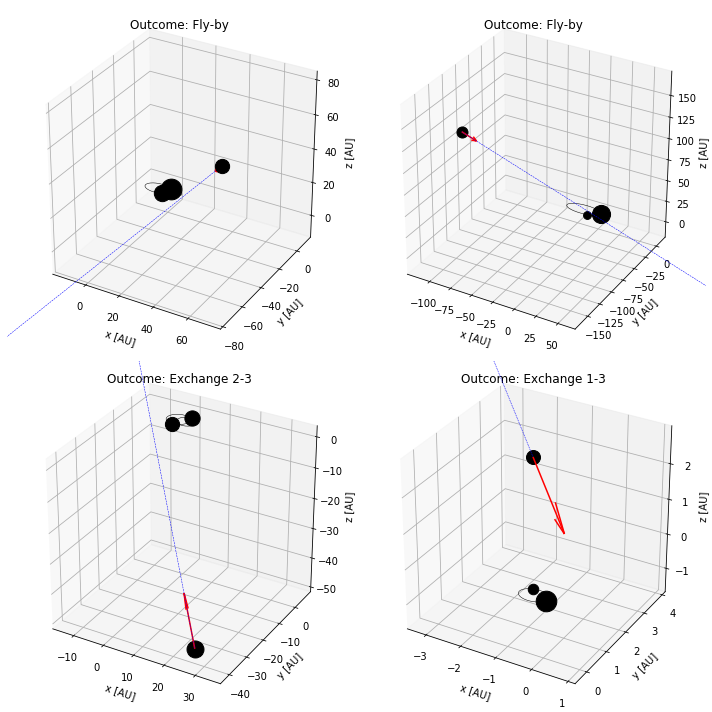

In [11]:
outcomes = np.array([ 'Fly-by' , 'Exchange 1-3' , 'Exchange 2-3' , 'Ionization' ])

fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(221, projection='3d')
plot_system(main_df.loc[5],ax = ax1,arrow_length=5)

ax2 = fig.add_subplot(222, projection='3d')
plot_system(main_df.loc[10],ax = ax2,arrow_length=5)

ax3 = fig.add_subplot(223, projection='3d')
plot_system(main_df.loc[2],ax = ax3,arrow_length=5)

ax4 = fig.add_subplot(224, projection='3d')
plot_system(main_df.loc[9001],ax = ax4,arrow_length=1)
plt.tight_layout()
plt.show()

## Exploration of the parameter space

<img src="Hut_initial_conditions.png" alt="drawing" width="300"/>

Image by [Hut et al (1983)](https://ui.adsabs.harvard.edu/abs/1983ApJ...268..319H/abstract)

### Masses of the Black Holes

The masses of the Black Holes are reported in Solar masses ($M_\odot$) where:
* $M_1$ is the more massive BH in the binary
* $M_2$ is the smaller BH
* $M_3$ is the mass of the single

These have been samples from the same mass distribution, found in simulations of YSCs from [Di Carlo et al. (2019)](https://academic.oup.com/mnras/article/487/2/2947/5499046), the differences in the histograms below arise just from how $M_1,M_2$ and $M_3$ are defined

Since $M_1$ is always bigger than $M_2$, in the Neural Network it will be always given as input as a ratio ($\frac{M_2}{M_1}$), an histogram below shows how this affects the parameter space of $M_2$

In [12]:
def hist_for_step(heights,edges):
    """Prepare the edges and heights to be plotted with plt.step"""
    return np.concatenate((np.array([0]),heights,np.array([0]))),np.concatenate((edges,np.array([edges[-1]]))) 

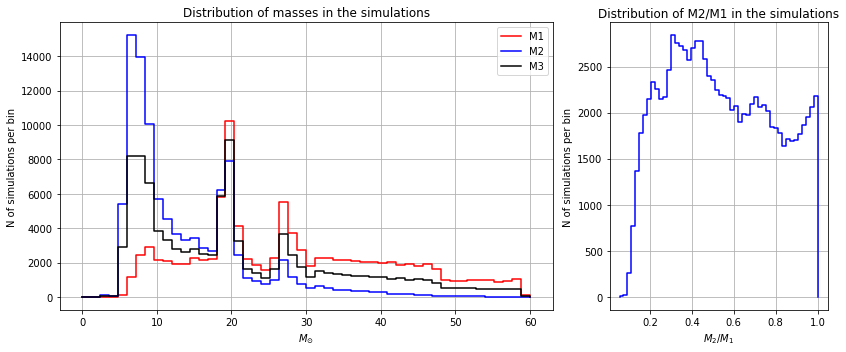

In [18]:
# Plot masses distribution
heights1,edges = hist_for_step(*np.histogram(main_df.m1,range=[0,60],bins=50,density=False))
heights2,edges = hist_for_step(*np.histogram(main_df.m2,range=[0,60],bins=50,density=False))
heights3,edges = hist_for_step(*np.histogram(main_df.m3,range=[0,60],bins=50,density=False))




plt.figure(figsize=[12,5])
plt.subplot2grid((1,3),(0,0),colspan=2)
plt.title('Distribution of masses in the simulations')
plt.step(edges,heights1,color='red'  ,label='M1')
plt.step(edges,heights2,color='blue' ,label='M2')
plt.step(edges,heights3,color='black',label='M3')
plt.grid()
plt.xlabel('$M_{\odot}$')
plt.ylabel('N of simulations per bin')
plt.legend()

#plot of the ratio
heights,edges =hist_for_step( *np.histogram(main_df.m2/main_df.m1,bins=50,density=False))
plt.subplot2grid((1,3),(0,2))
plt.title('Distribution of M2/M1 in the simulations')
plt.step(edges , heights , color='blue')

plt.grid()
plt.xlabel('$M_2/M_1$')
plt.ylabel('N of simulations per bin')
plt.tight_layout()
plt.show()



### Binary orbital parameters
The semi major axis $a$ is sampled form a log normal distribution, but with limits $[min(a_{gw},a_{ej}) , a_{hard}]$, different for eaach simulation, where:
* $a_{gw}$ and $a_{ej}$ are set respectively such that "natural" GW emission does not cause a premature merger of the binary and 3 body interactions will not cause the system to be expelled from the cluster
* $a_{hard}$ is set to avoid having soft binaries

For the neural network $a$ will be rescaled to the interval it was sampled from, so that it will always have values between 0 and 1.
This provides also a better cover of the parameter space.

Eccentricity ($e$) is sampled from a uniform distribution in $e^2$, while the orbital phase ($f$) is sampled form a different distribution.


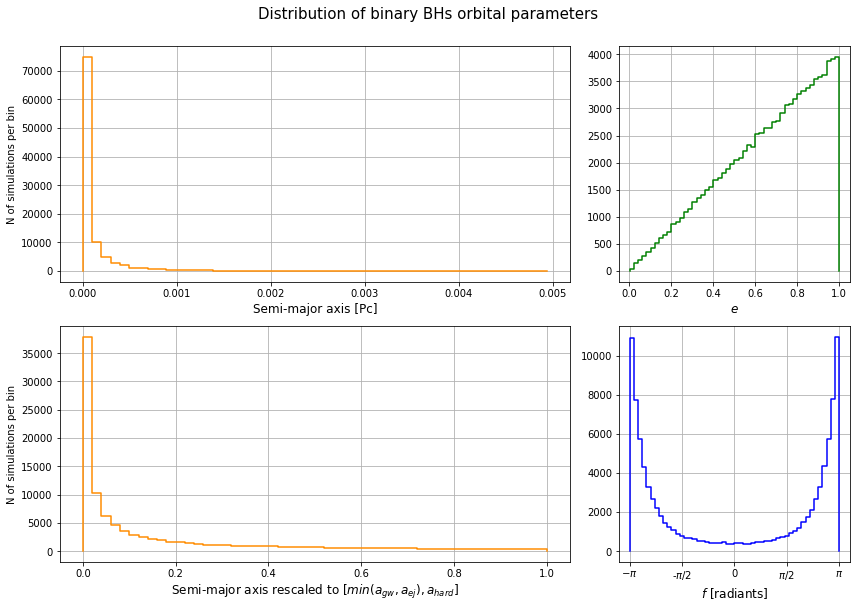

In [21]:
plt.figure(figsize=[12,8])
plt.suptitle('Distribution of binary BHs orbital parameters',y = 1.05,fontsize = 15)

# b and b_max plot
heightsa,edgesa = hist_for_step( *np.histogram(main_df.a,bins=50,density=False) )
min_limit = np.min([main_df.a_ej,main_df.a_gw],axis=0)
heightsanorm,edgesanorm = hist_for_step( *np.histogram((
                                        main_df.a-min_limit)/(main_df.a_hard-min_limit),bins=50,density=False))
plt.subplot2grid((2,3),(0,0),colspan=2) #b
plt.step(edgesa,heightsa,color='darkorange'  ,label='b')
plt.ylabel('N of simulations per bin')
plt.xlabel('Semi-major axis [Pc]',fontsize = 12)
plt.grid()

plt.subplot2grid((2,3),(1,0),colspan=2)#b/b_mx
plt.step(edgesanorm,heightsanorm,color='darkorange'  ,label='b')
plt.ylabel('N of simulations per bin')
plt.xlabel('Semi-major axis rescaled to $[min(a_{gw},a_{ej}) , a_{hard}]$',fontsize = 12)
plt.grid()

# eccentricity
heightse,edgese = hist_for_step( *np.histogram(main_df.e,bins=50,density=False) )
plt.subplot2grid((2,3),(0,2))
plt.step(edgese,heightse,color='green'  ,label='b')
#plt.ylabel('N of simulations per bin')
plt.xlabel('$e$',fontsize = 12)
plt.grid()

# phase
heightse,edgese = hist_for_step( *np.histogram(main_df.f,bins=50,density=False))
plt.subplot2grid((2,3),(1,2))
plt.step(edgese,heightse,color='blue'  ,label='b')
#plt.ylabel('N of simulations per bin')
plt.xlabel('$f$ [radiants]',fontsize = 12)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],labels = ['$-\pi$','-$\pi$/2','0','$\pi$/2','$\pi$'])
plt.grid()

plt.tight_layout()
plt.show()

### Single BH approach parameters

The parameters for the single BH are 

* The magnitude of the velocity at infinity $v_{\infty}$ , sampled from a maxwellian distribution, measured in km/s
* The impact parameter $b$ it is sampled uniformly from $b^2$ with extremes $[0,b_{max}]$, where$b_{max}$ is set to  ensure that there is a hard encounter.
* The angles of approach $\phi$ and $\psi$ are sampled uniformly from $[0,2\pi]$ while $\theta$ is sampled in $[-1,1]$ from $cos(\theta)$

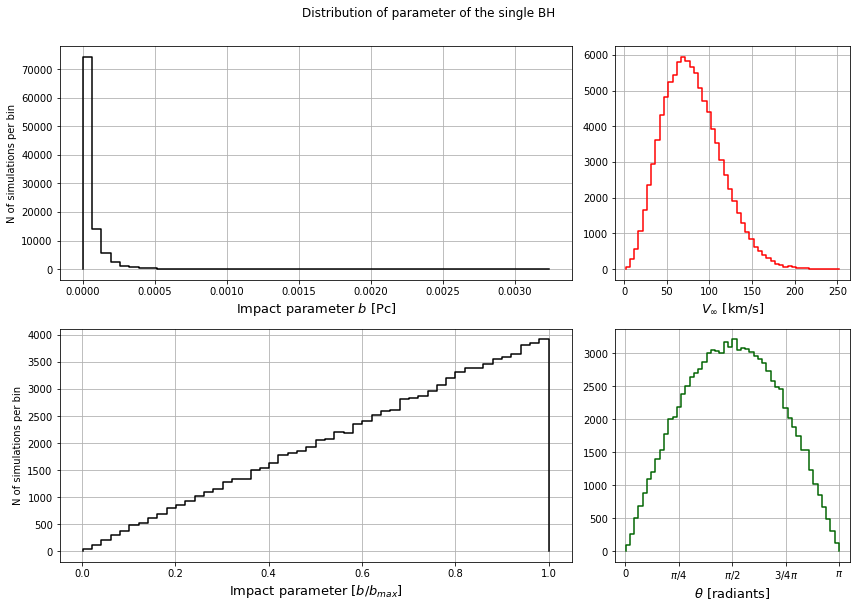

In [24]:
plt.figure(figsize=[12,8])
plt.suptitle('Distribution of parameter of the single BH',y=1.05)

heights,edges = hist_for_step(*np.histogram(main_df.v,bins=50,density=False))
plt.subplot2grid((2,3),(0,2))
plt.step(edges , heights , color='red'  ,label='Velocity')
plt.grid()
plt.xlabel('$V_{\infty}$ [km/s]',fontsize=13)
#plt.ylabel('Density')


heightsb,edges1 = hist_for_step(*np.histogram(main_df.b,bins=50,density=False))
heightsbnorm,edges2 = hist_for_step(*np.histogram(main_df.b/main_df.b_max,bins=50,density=False))

plt.subplot2grid((2,3),(0,0), colspan = 2 )
plt.step(edges1,heightsb,color='black'  ,label='b')
plt.xlabel('Impact parameter $b$ [Pc]',fontsize=13)
plt.ylabel('N of simulations per bin')
plt.grid()

plt.subplot2grid((2,3),(1,0), colspan = 2 )
plt.step(edges2,heightsbnorm,color='black'  ,label='b')
plt.xlabel('Impact parameter [$b$/$b_{max}$]',fontsize=13)
plt.ylabel('N of simulations per bin')
plt.grid()


heights,edges = hist_for_step(*np.histogram(main_df.theta,bins=50,density=False))
plt.subplot2grid((2,3),(1,2))
plt.step(edges , heights , color='darkgreen'  ,label='Velocity')
plt.xlabel('$\\theta$ [radiants]',fontsize=13)
plt.xticks([0, np.pi/4 , np.pi/2,3/4*np.pi,np.pi],labels = ['0','$\pi$/4','$\pi$/2','3/4$\pi$','$\pi$'])
#plt.ylabel('Density')
plt.grid()

plt.tight_layout()
plt.show()

### Outcomes

The aim of this project is learning the general outcome of a BH-BBH encounter and not the specific orbital parameters at the end of the simulation. This simplifies the scope of the algorithm but also limits the possible uses.

The possible outcomes are:

|Index | Outcome      | Description|
|------|---------     |------------|
| 0    | Fly-by       | The binary BHs remain as a binary at the end of the simulation |
| 1    | Exchange 1-3 | The smaller BH in the binary is replaced by the single BH|
| 2    | Exchange 2-3 | The bigger BH in the binary is replaced by the single BH |
| 3    | Ionization   | No binaries remain at the end of the simulation |

As is possible to see from the plot below, some outcomes are more probable than others and will depend on the probability distributions of the initial conditions.

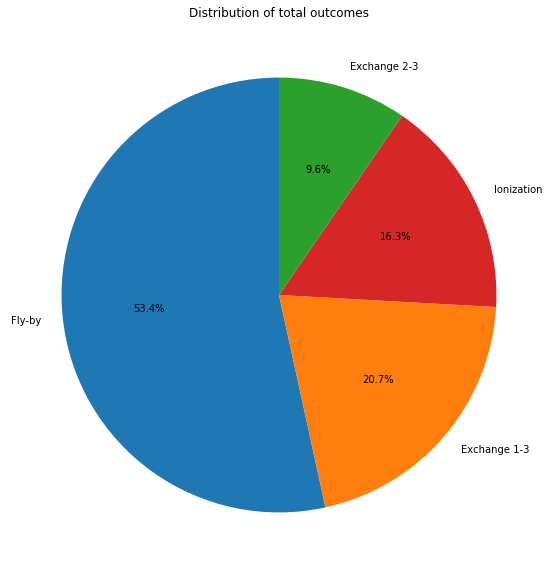

In [418]:
_,counts = np.unique(main_df.OUTCOME,return_counts=True)
outcomes = np.array([ 'Fly-by' , 'Exchange 1-3' , 'Exchange 2-3' , 'Ionization' ])
ii = np.argsort(counts)[::-1] #orders the pie chart from smallest percentage to biggest.


fig = plt.figure(figsize=[10,10])
plt.title('Distribution of total outcomes')
colors = np.array(['C0','C1','C2','C3'])# this is done to ensure color standardization of the outcomes throught the notebook
fig.set_facecolor('white') #this is done to avoid transparent bg
plt.pie( counts[ii] , labels = outcomes[ii],colors = colors[ii],autopct='%1.1f%%',startangle=90)
plt.show()



## Neural Network training

### Definition of the dataset classes
To ease pytorch in his work and readability, it is defined a `Dataset` class. This transforms the pandas dataframe object in a pytorch tensor, also it applies the transformation of the data that will be talked more throughtly in the next section.

In [25]:
# The class for the datasets, it implements implements transformations
# most of them during the init call. This was done to save computational time, since the transformation
# call ,for some reason, is incredibly expensive, whilemore compatible with the pytorch phylosophy
class dfToTensorDataset(Dataset):
    
    
    def __init__(self, df, transform_df, mask,transform=None):

        """
        Class that has the aim to speed up the data retrival, since now it's a mayor bottleneck.
        Expects the dataframe to already be normalized.
        
        Args:            
            df (pandas datafrme)          : Must be a pandas dataframe with the given stucture 
                                            with the initial conditions and the right outputs, refer to the readme
            transform_df (function)       : Function that will be applied to the dataframe to transform it
            transform (callable, optional): Optional transform to be applied
                                            on a sample.
            mask (bool array)             : Mask to be applied to the input columns
                                            Default : None
                                            
            
        """
        
        self.transform = transform
        
        df = transform_df(df)
        
        #if mask:
        self.data      = torch.Tensor( np.array( df[transform_df.mask] ) )
            
        #else:
        #    self.data      = torch.Tensor( np.array( df.iloc[ : , 1:14 ] ) )
            
        self.labels    = torch.tensor( np.array( df.OUTCOME ) , dtype = torch.long)
        
    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):

        sample = self.data[idx]
        label  = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)

        return (sample,label)

### Transformaton class

To facilitate network training, the input variables need to be rescaled so they all coexist in a similar range. The chosen iterval for most of the variables is set to be  around $[-1,1]$ and this is achieved by appling

<span style="font-size:1.5em;">$x_{NN} = \frac{ x_0 - \overline{x_0}}{std(x_0)}$</span>

Where $x_0$ is the initial value of the variable, $\overline{x_0}$ and $std(x_0)$ are the mean and standard deviation between all $x_0$s in the dataframe and $x_{NN}$ is the variable that will be fed to the network.

A different approach has been chosen for the angles, where the sinuses and cosinuses of each variable are fed to the network instead.
This approach has been chosen both to rescale the variable to a sensible interval and to impose periodicity on the output function in these variables

For the variables sampled from an interval that varies depending on the simulation (Semi major axis $a$ and impact parameter $b$), their values are rescaled to that interval instead.

To facilitate the network further in predicting the correct outcome, a variable called `v_crit_indicator` is also fed to the network , which is set to 1 whenever the velocity of the intruder is more than the **critical velocity**, or in other words the minimum velocity that is needed in order for the intruder to cause the ionization of the binary.


<span style="font-size:1.5em;">$ v_{crit} = \sqrt{\frac{m_1 m_2 (m_1+m_2+m_3)}{m_3 a (m_1+m_2)}} $</span>





In [27]:
def v_crit(d):
    """Calculates the critical velocity for a determined system
        Args:
             d (pandas.DataFrame)     : dataframe containing initial conditins of BH-BBh encounters"""
    return np.sqrt( (d.m1*d.m2*(d.m1+d.m2+d.m3) ) / (d.m3*(d.m1+d.m2)*d.a) )*k

def v_critT(T):
    vals = T[ : , 0:4 ]*stdsT[1:5] + meansT[1:5]
    return torch.sqrt(vals[:,0]*vals[:,1]*( vals[:,0:3].sum(axis=1) ) )
G       = 6.6740e-11
L_scale = 3.0857e16
M_scale = 1.988e30
T_scale = (L_scale**3/M_scale)**0.5
k = np.sqrt(M_scale/L_scale*G)*1e-3 # constant needed to scale critical velocity to km/s  


Defining a class for the transformation:

In [28]:
class NormalizeDataFrame(object):
    
    """Function needed to normalize dataframes such that machine learning can be applied to them.
        init Args:
            means   (pandas.Series)   : means of each of the columns to normalize
            stds    (pandas.Series)   : stds of each of the columns to normalize  
            col_to_normalize (list)   : list that contains the columns that need to be normalized
            angles           (list)   : angles that need to be passed
            v_crit_ind       (bool)   : If True, a column with 1 if the encounters happen at velocity lower 
                                        than the critical velocity
            norm_a           (bool)   : If true, a will be normalized using arguments a_ej, a_gw and a_hard
            
        __call__ Args :
            main_df (pandas.DataFrame): Data frame on wich normalization will be applied
            
        NOTE: the class contains the arguments self.mask, that is actually needed for a few of the other functions!
            """

    def __init__(self, means, stds , col_to_normalize , angles , v_crit_ind = True, norm_a =True,
                 m2_as_ratio = False, m3_as_ratio = False):
        
        self.means = means
        self.stds = stds
        self.col_to_normalize = col_to_normalize
        self.angles = angles
        self.v_crit_ind = v_crit_ind
        self.norm_a = norm_a
        self.m2_as_ratio = m2_as_ratio
        self.m3_as_ratio = m3_as_ratio
        
        self.sins   = ['sin' + angle for angle in self.angles]
        self.coss   = ['cos' + angle for angle in self.angles]       
        
        self.mask = self.col_to_normalize + self.sins + self.coss + ['theta'] + ['b']

        self.mask = self.mask + ['imp_ion'] if self.v_crit_ind else self.mask
     
    def __call__(self , main_df):

        norm_df = main_df.copy()

        if self.v_crit_ind:
            norm_df["imp_ion"] =np.float64(norm_df.v < v_crit(norm_df)) 


        # Normalize the main dataframe, this is done to make the input more friendly to work with for the Neural network, use 
        norm_df[self.col_to_normalize] = ( norm_df[ self.col_to_normalize ] - self.means[ self.col_to_normalize ])/self.stds[ self.col_to_normalize ]

        # For b we try to divide b by the b_max parameter

        norm_df.b = norm_df.b/norm_df.b_max
        norm_df.b = norm_df.b - means.b 

        #Other ratios, check if we have to divide
        if self.m3_as_ratio:# m3 expressed as a ratio of the total mass of the binary
            norm_df.m3 = main_df.m3/(main_df.m1+main_df.m2) 
            
        if self.m2_as_ratio:# m2 expressed as a ratio of the 1m1 mass
            norm_df.m2 = main_df.m2/main_df.m1
        
        if self.norm_a:# a expressed as a ratio between the smallest and the biggest parameter that has been sampled.
            min_limit = np.min([main_df.a_ej,main_df.a_gw],axis=0)
            norm_df.a = (main_df.a-min_limit)/(main_df.a_hard-min_limit)

        norm_df[ self.sins ] = np.sin(norm_df[ self.angles ])
        norm_df[ self.coss ] = np.cos(norm_df[ self.angles ])

        norm_df.theta = 2*norm_df.theta/np.pi - 1

        return norm_df

In [62]:
#Define the seed for repeatable oucomes
torch.manual_seed(0)
#Means and stds arrays for each variable
means = main_df.mean()
stds = main_df.std()
#the mean of b is defined with the ratio between b and b_max in mind
means.b = np.mean(main_df.b/main_df.b_max) 

# Define which columns to use, and which are to be normalized and wich are angles
angles           = ['phi'   , 'psi'   , 'f']
col_to_normalize = ['m1' ,'m2',  'm3' , 'a' , 'e' , 'v']

transform_df = NormalizeDataFrame( means, stds, col_to_normalize, angles,
                                  norm_a      = True, # whether to normalize a
                                  v_crit_ind  = True, # whether to include the v_crit_ind variable
                                  m2_as_ratio = True, # whether to describe m2 as m2/m1
                                  m3_as_ratio = False )# whether to describe m3 as m3/(m1+m2)

mask = transform_df.mask # define which columns are needed 

norm_df = transform_df(main_df)#test

### Training, validation and test division and batches subdivision
Here the 100 000 simulations are divided in the training, validation and test sets. Since the great number of data available and since the mostly homogenous and "noiseless" nature of the distribution of the data, the percentages of the different sets has been chosen to be 90-5-5 %.

The `Dataloader` method of pytorch allows for a division in batches and a random shuffle of the data each time it is called for training. The batch size of 256 seems to be the best performing one.

In [63]:
# Division in train , test and validation datasets, use norm_df if it's not in the transformations 
# stratify is there to help to split the dataset so that the outcomes are equally distributed between classes
train_df , test_df = train_test_split(main_df,  test_size=0.1, stratify=main_df.OUTCOME, shuffle=True, random_state=0)
test_df  , val_df  = train_test_split(test_df,  test_size=0.5, stratify=test_df.OUTCOME, shuffle=True, random_state=0)


In [64]:
# Tranform data into dataset classes
test_dataset   = dfToTensorDataset( test_df  , transform_df, transform = None, mask = mask)
val_dataset    = dfToTensorDataset( val_df   , transform_df, transform = None, mask = mask)
train_dataset  = dfToTensorDataset( train_df , transform_df, transform = None, mask = mask)

In [65]:
num_workers = 0 #PC
#num_workers = 2 #####COLAB ENABLED
batch_size = 256

train_dataloader = DataLoader(train_dataset , batch_size = batch_size        , shuffle = True  , num_workers=num_workers)
val_dataloader   = DataLoader(val_dataset   , batch_size = len(val_dataset)  , shuffle = False , num_workers=num_workers)
test_dataloader  = DataLoader(test_dataset  , batch_size = len(test_dataset) , shuffle = False , num_workers=num_workers)

In [66]:
# timing and example sample test
for i,b in tqdm(train_dataloader,position=0,leave=True,disable=False):
    a=0
train_dataset[0][0]


100%|███████████████████████████████████████████████████████████████████████████████| 352/352 [00:00<00:00, 711.19it/s]


tensor([-1.0946,  0.6526,  1.2230,  0.1289,  1.2788,  0.2493,  0.1621,  0.9981,
         0.2099, -0.9868,  0.0619, -0.9777,  0.3061,  0.1232,  0.0000])

### Definition of the Network class

The machine learning framework chosen is a fully-connected Neural Network.

Below are present the pytorch classes that create the actual network, of which two have been made, one version with 3 hidden layers and one with 4. The function to initialize the weights is also included. 


In [67]:
# Function to be applied to the sequential layer, will inizialize network with xavier normal
def init_weights(m):
    """Function to initialize weights in a layer"""
    if isinstance(m, torch.nn.Linear):
        
        # gain is a parameter to be given to the xavier normal to decide the std, depends on the activation
        torch.nn.init.xavier_normal_(m.weight , torch.nn.init.calculate_gain( 'relu' ) )
        m.bias.data.fill_(0.01)

In [68]:
class Net(nn.Module):
    
    """Network class, contains 3 hidden layers"""
    
    def __init__(self, Ni, Nh, No , pDropout=0.0, init_func=init_weights):
        """
        Args:
        Ni (int)                : Input size
        Nh (series of lenght 3) : Hidden layers size
        No (int)                : Output size
        Act                     : At the moment does nothing
        pDropout (float [0,1] ) : Probability of dropout
        init_func (function)    : Function to be applied to inizialize Tensors 
        """
        super().__init__()
        
        print('Network initialized')
        self.FCLayers = torch.nn.Sequential(
            
            #First hidden Layer
            torch.nn.Linear( Ni , Nh[0] ),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Second Layer
            torch.nn.Linear(Nh[0],Nh[1]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Third Layer
            torch.nn.Linear(Nh[1],Nh[2]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Output Layer
            torch.nn.Linear(Nh[-1],No)            
        )
        
        #Inizialization
        self.FCLayers.apply(init_func)

        
    def forward(self, x):
        return self.FCLayers(x)
    
class Net4(nn.Module):
    
    """Network class, contains 3 hidden layers"""
    
    def __init__(self, Ni, Nh, No , pDropout=0.0, init_func=init_weights):
        """
        Args:
        Ni (int)                : Input size
        Nh (series of lenght 3) : Hidden layers size
        No (int)                : Output size
        Act                     : At the moment does nothing
        pDropout (float [0,1] ) : Probability of dropout
        init_func (function)    : Function to be applied to inizialize Tensors 
        """
        super().__init__()
        
        print('Network initialized')
        self.FCLayers = torch.nn.Sequential(
            
            #First hidden Layer
            torch.nn.Linear( Ni , Nh[0] ),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Second Layer
            torch.nn.Linear(Nh[0],Nh[1]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Third Layer
            torch.nn.Linear(Nh[1],Nh[2]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Fourth Layer
            torch.nn.Linear(Nh[2],Nh[3]),
            torch.nn.Dropout(pDropout),
            torch.nn.ReLU(True),
            
            #Output Layer
            torch.nn.Linear(Nh[-1],No)
        )
        
        #Inizialization
        self.FCLayers.apply(init_func)

        
    def forward(self, x):
        return self.FCLayers(x)

### Netework and training parameters that perform the best:

|Network parameters| Value|
|--------------|------|
|Input Layer        | 15     |
|Output layer       | 4      |
|Hidden layers sizes| 256, 256, 256, 256|
|Activation function| ReLU   |
|Dropout            | 0.3    |
|Weights Initializatin| Xavier Normal| 


|Optimizer parameter |Value|
|--------------------|-----|
|Optimizer           |Adamax|
|Learning rate       |0.002 |
|Weight decay        |2e-5  |

|Loss parameters | Value|
|--------------|------|
|Loss function|Cross-enthropy loss|
|Class weights|0.21 , 0.21 , 0.31 , 0.27|



Class weights are applied to the loss function, since the outcomes are not equally distributed. This may cause a worse performing network overall but with a more balanced performance over all of the classes.

In [107]:
# Network inizialization
Ni = len(transform_df.mask) # Input nodes
Nh = [256 , 256, 256, 256 ] # Hidden nodes
No = 4                      # Output nodes

pDrop = 0.3            # Dropout

First_net = Net4(Ni , Nh , No , pDrop)

# Optimizer inizialization
lr           = 0.002#1e-3
weight_decay = 2e-5 # Paramter used to calibrate regularization
optimizer = optim.Adamax(First_net.parameters() , lr = lr , weight_decay = weight_decay)

# Loss function
class_weights = torch.Tensor([ 0.21 , 0.21 , 0.31 , 0.27 ])
loss_fn = torch.nn.CrossEntropyLoss(weight = class_weights )
#loss_fn = torch.nn.NLLLoss(weight = class_weights )

First_net

Network initialized


Net4(
  (FCLayers): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=256, out_features=4, bias=True)
  )
)

### Functions to train and validate the outputs 

In [108]:

def train_epoch(net, device, dataloader, loss_fn, optimizer, verbose=0, m = None, c = None, disable_tqdm=True):
    """Function to advance training one step"""
    # Set train mode
    net.train()
    for train_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
        # Move tensors to the selected device
        train_batch = train_batch.to(device)
        label_batch = label_batch.to(device)
        # Forward pass
        out = net(train_batch)
        # wether to apply softmax to the output
        if m:
             out = m(out)
        # Evaluate loss
        loss = loss_fn(out, label_batch)
        
        if c:
            out2 = sm(out)
            loss = loss +  torch.mean( train_batch[:,-1]*out2[:,3] )*c
        # Backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        if verbose==2:
            print('\t Training loss (single batch):', float(loss.data))
            
            
### Testing function
def test_epoch(net, device, dataloader, loss_fn, m=None,disable_tqdm=True):
    # Set evaluation mode
    net.eval()
    with torch.no_grad():
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in tqdm(dataloader,position=0,leave=True,disable=disable_tqdm):
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # Forward pass
            out = net(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        if m:
            conc_out = m(conc_out)
        val_loss = loss_fn(conc_out, conc_label)
    return conc_out, conc_label, val_loss.data # We return all the outputs, all the labels and the global loss


def train_func(First_net , train_dataloader ,val_dataloader , device, loss_fn, optimizer,verbose = 1, num_epochs=50, m=None, disable_tqdm=True ):
    ### TRAINING!

    train_losses = []
    val_losses = []

    sm = nn.Softmax(dim=1)

    for epoch in range(num_epochs):
        print(f"EPOCH {epoch + 1}/{num_epochs}")
        ### Training 
        train_epoch(
            net=First_net,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optimizer,
            verbose=verbose,m=m,
            disable_tqdm=disable_tqdm)

        ### Train loss 
        _, _, train_loss = test_epoch(
            net=First_net,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn,m=m,
            disable_tqdm=disable_tqdm)

        # Print Train loss
        if verbose >=1:
            print(f"\n\n\t TRAIN - EPOCH {epoch + 1}/{num_epochs} - train loss: {train_loss}\n\n")
        train_losses.append(train_loss)

        ### Validation 
        _, _, val_loss = test_epoch(
            net=First_net,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn,m=m,
            disable_tqdm=disable_tqdm)

        # Print Validation loss
        if verbose>=1:
            print(f"\n\n\t VALIDATION - EPOCH {epoch + 1}/{num_epochs} - val loss: {val_loss}\n\n")
        val_losses.append(val_loss)
        
    return train_losses, val_losses


#### Train the network 
The network has been trained for 60 epochs, this is the point after wich overfitting starts to take over

In [109]:
train_losses, val_losses = train_func(First_net=First_net,
        device=device, 
        train_dataloader=train_dataloader, 
        val_dataloader=val_dataloader,
        loss_fn=loss_fn, 
        optimizer=optimizer,
        verbose=0,num_epochs=60)

EPOCH 1/60
EPOCH 2/60
EPOCH 3/60
EPOCH 4/60
EPOCH 5/60
EPOCH 6/60
EPOCH 7/60
EPOCH 8/60
EPOCH 9/60
EPOCH 10/60
EPOCH 11/60
EPOCH 12/60
EPOCH 13/60
EPOCH 14/60
EPOCH 15/60
EPOCH 16/60
EPOCH 17/60
EPOCH 18/60
EPOCH 19/60
EPOCH 20/60
EPOCH 21/60
EPOCH 22/60
EPOCH 23/60
EPOCH 24/60
EPOCH 25/60
EPOCH 26/60
EPOCH 27/60
EPOCH 28/60
EPOCH 29/60
EPOCH 30/60
EPOCH 31/60
EPOCH 32/60
EPOCH 33/60
EPOCH 34/60
EPOCH 35/60
EPOCH 36/60
EPOCH 37/60
EPOCH 38/60
EPOCH 39/60
EPOCH 40/60
EPOCH 41/60
EPOCH 42/60
EPOCH 43/60
EPOCH 44/60
EPOCH 45/60
EPOCH 46/60
EPOCH 47/60
EPOCH 48/60
EPOCH 49/60
EPOCH 50/60
EPOCH 51/60
EPOCH 52/60
EPOCH 53/60
EPOCH 54/60
EPOCH 55/60
EPOCH 56/60
EPOCH 57/60
EPOCH 58/60
EPOCH 59/60
EPOCH 60/60


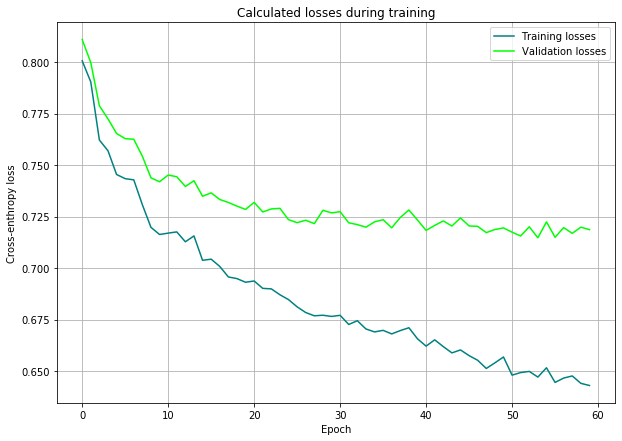

In [110]:
# Plot train and validation losses throught training.
plt.figure(figsize=[10,7])
plt.title('Calculated losses during training')
plt.plot(train_losses, label = 'Training losses',   color = 'teal'  )
plt.plot(val_losses,   label = 'Validation losses', color = 'lime' )
plt.ylabel('Cross-enthropy loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [114]:
net_state_dict = First_net.state_dict()# Saving the network
torch.save(net_state_dict, 'net_parameters.torch')# Save the state dict to a file

After $\sim$ 30 epochs, there are no more gains on the validation set but only on the training set. Since too much overfitting is to be avoided, the training is halted a while later.

## In depth analysis on the prediction on the validation and test sets.
### Confusion matrixes and outcome distribution

Now  let's take a deeper look on the predictions of the network over the train and test sets.

The network outputs four nodes, one for each class. To interpret the outcomes the Softmax function is applied to the output of the network so that the sum of the value of the nodes is equal to 1 and can be interpreted as "probabilities that an input belongs to a certain class". This formalism is not exacly correct but is good enought for our pourposes.

The next section section will be focused on the study of which class the network outputs as the most probable for each input conditions and compared to the actual ouput class predicted by the simulation. The graph below shows the overall  distribution of outcomes


In [103]:
# Loading the network if training is to be skipped
First_net = Net4(Ni, Nh, No) 
net_state_dict = torch.load('net_parameters.torch')
First_net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

In [111]:
sm = torch.nn.Softmax(dim=1)

val_out, val_label,valloss = test_epoch(First_net,device,val_dataloader,loss_fn)
val_out        = np.array(sm(val_out))
val_out_labels = np.argmax(val_out,axis=1)
val_acc = 100*(sum(np.array(val_label)==val_out_labels))/val_out_labels.shape


test_out, test_label,testloss = test_epoch(First_net,device,test_dataloader,loss_fn)
test_out        = np.array(sm(test_out))
test_out_labels = np.argmax(test_out,axis=1)
test_acc = 100*(sum(np.array(test_label)==test_out_labels))/test_out_labels.shape

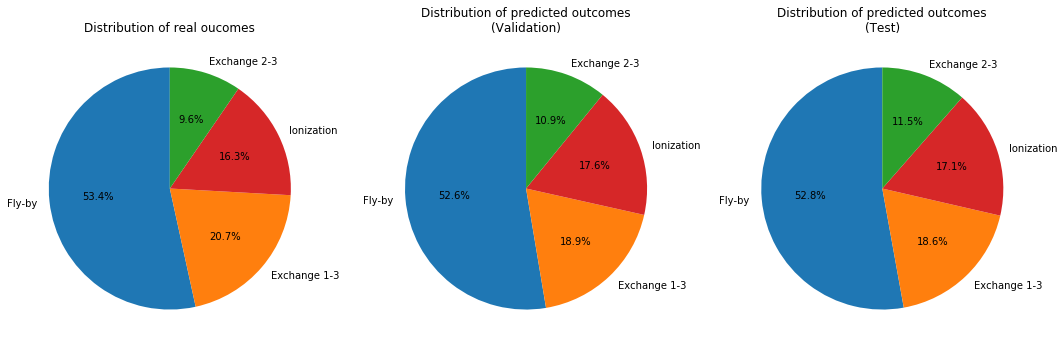

In [112]:
_,realcounts    = np.unique(main_df.OUTCOME,return_counts=True)
_,predictvalcounts = np.unique(val_out_labels ,return_counts=True)
_,predictestcounts = np.unique(test_out_labels ,return_counts=True)

outcomes = np.array([ 'Fly-by' , 'Exchange 1-3' , 'Exchange 2-3' , 'Ionization' ])
ii = np.argsort(realcounts)[::-1] #orders the pie chart from smallest percentage to biggest.
jj = np.argsort(predictvalcounts)[::-1]
kk = np.argsort(predictestcounts)[::-1]

colors = np.array(['C0','C1','C2','C3'])# this is done to ensure color standardization of the outcomes throught the notebook

fig,ax = plt.subplots(1,3,figsize=[15,5])
ax[0].set_title('Distribution of real oucomes')
ax[1].set_title('Distribution of predicted outcomes\n(Validation)')
ax[2].set_title('Distribution of predicted outcomes\n(Test)')
ax[0].pie( realcounts[ii] , labels = outcomes[ii],colors = colors[ii],autopct='%1.1f%%',startangle=90)
ax[1].pie( predictvalcounts[jj] , labels = outcomes[jj],colors = colors[jj],autopct='%1.1f%%',startangle=90)
ax[2].pie( predictestcounts[kk] , labels = outcomes[kk],colors = colors[kk],autopct='%1.1f%%',startangle=90)

fig.set_facecolor('white') #this is done to avoid transparent bg
plt.tight_layout()
plt.show()

As it is possible to see the output distribution mimics closely the input one. There is quite remarkable similarities between validation and test distribution , which is a good sign that the network is learning a more general rule. 
### Confusion matrices

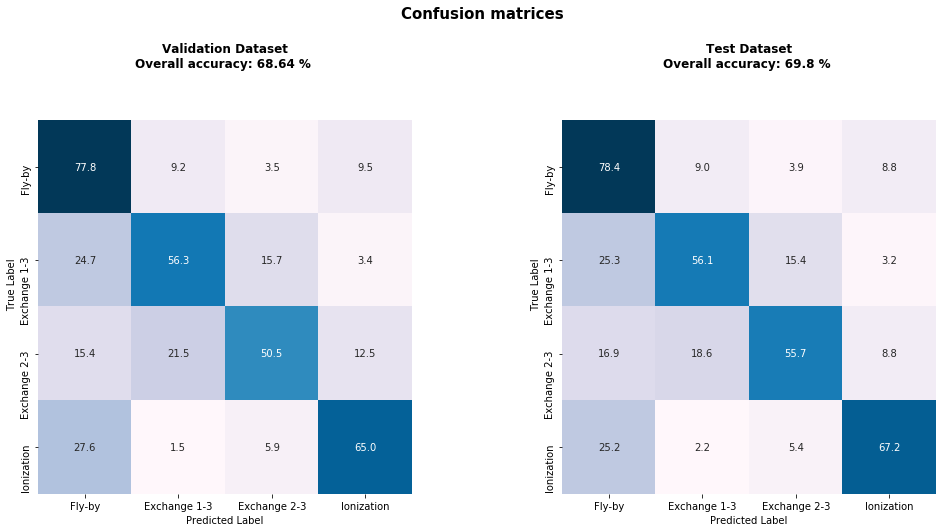

In [113]:
fig,axis=plt.subplots(1,2,figsize=[15,7])
plt.suptitle('Confusion matrices',y=1.05,fontsize=15,weight='bold')

for labels, out_labels, acc, title ,ax in zip((val_label,test_label), (val_out_labels,test_out_labels),
                                              (val_acc,test_acc),('Validation','Test'),axis):
    Conf_matrix = np.zeros([ 4 , 4 ])
    for i in np.arange(4):

        mask = np.array(labels) == i
        Conf_matrix[ i , : ] = np.unique( out_labels[ mask ] , return_counts = True )[1]/mask.sum()
    df_Confusion = pd.DataFrame( Conf_matrix*100 , outcomes , outcomes )



    sns.heatmap(df_Confusion, ax = ax, cmap = 'PuBu', square = True, annot = True , fmt = '.1f', 
                cbar = False, cbar_kws = {"shrink": 0.56} )

    ax.set_title(title + f' Dataset\nOverall accuracy: {acc[0]} % ', fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

    ax.set_ylim(4,-0.5, -0.5)
plt.tight_layout()
plt.show()

As one could expect, the best outcome prediction is in the Fly-by class, since it is the one with more examples in the network, obtaining a $\sim$ 70 % accuracy. 

The two exchange classes both seems to confuse the network which is not quite capable of always correctly label them, getting $\sim$ 50% accuracy. This can be expected, since these outcomes come from the most chaotic of simulations.

The ionization class gets a $\sim$ 66 % accuracy, when the most common misslabelling is with the fly-by class.


## More in depth study of the output function of the network. 

This section will study the network output in more detail. To see how changing one parameter affects the output of the network, every input parameter of the simulation is fixed but one, and varing this last it in the parameter space probed by the network. The focus will be on some specific parameters: $M_1$, $M_3$ and the impact parameters will be shown alone , while a double-parameter study will be performed on the $\phi$-$\theta$, $M_1$-$M_2$ and $v_{\infty}$-$a$ pairs, producing some topology maps. Each output is computed fixing the parameters of a random simulation from the validation dataset.

In [84]:
cols_extremes = {'m1'   : (5  , 100),
                'm2'   : (3  , 60),
                'm3'   : (60 , 140),
                'v'    : (0  , 20),
                'theta': (0  , np.pi),
                'psi'  : (0  , 2*np.pi),
                'phi'  : (0  , 2*np.pi),
                'f'    : (-np.pi , np.pi),
                'a'    : (0  , 0.005),
                'e'    : (0  , 1),
                'b'    : (0  , 1 )}


cols_extremes = {'m1'  : (6  , 60),
                'm2'   : (6  , 60),
                'm3'   : (6  , 60),
                'v'    : (0  , 200),
                'theta': (0  , np.pi),
                'psi'  : (0  , 2*np.pi),
                'phi'  : (0  , 2*np.pi),
                'f'    : (-np.pi , np.pi),
                'a'    : (0  , 0.005),
                'e'    : (0  , 1),
                'b'    : (0  , 1)}

def network_output_1D(base_params, col_to_change, transform_df , res = 100 , plot = True, ax=None , **kwargs ):
    
    """
    Function thats explores the network output by varing a parameter across a given range
    Args:
        base_params (pandas.Series)   : paramters to feed the network with
        col_to_change (str)           : Name of the column with paramters that will be varied
        res (int)                     : Number of points
        plot (bool)                   : If true, a plot will also be displayed
    """
    cols_extremes['b'] = (0,base_params.b_max)
    
    cols_extremes['a'] =  ( np.min( [base_params.a_ej , base_params.a_gw ] , axis = 0 ) , base_params.a_hard) if transform_df.norm_a else cols_extremes['a']

    df2 = pd.DataFrame([base_params]*res)# dataframe that will contain the input of the network
    
    # if statement in place to deal with the b parameter
    if col_to_change in cols_extremes.keys(): 
        
        real_value = base_params[col_to_change]
        f =  np.linspace(*cols_extremes[col_to_change] , res ) # parameter space of the variable            
        df2[col_to_change] = f
    
    #df2 = transform_df(df2)# data preparation
    
    #continue to deal with b
    if col_to_change == 'b':
        real_value = base_params.b/base_params.b_max 
        f = f/base_params.b_max
        
    if col_to_change == 'a':
        min_val = np.min( [base_params.a_ej , base_params.a_gw ] )
        real_value = (base_params.a- min_val) /(base_params.a_hard-min_val)
        f = np.linspace(0,1,res)

    

    topo_dataset      = dfToTensorDataset(df2,transform_df,transform_df.mask)
    topo_dataloader   = DataLoader(topo_dataset   , batch_size = len(topo_dataset)  , shuffle = False , num_workers=num_workers)
    # Test the network!
    conc_out, _, _  = test_epoch(First_net, device,topo_dataloader,loss_fn) 
    # transform the output in a usable form
    sm = torch.nn.Softmax(dim=1)
    topo_out        = np.array(sm(conc_out))*100
    topo_out_labels = np.argmax(topo_out,axis=1)
    
    
    if plot:
        

        if ax is None:
            fig, ax = plt.subplots(figsize=(15,7))

        ax.plot(f,topo_out[:,0], label = 'Fly by')
        ax.plot(f,topo_out[:,1], label = 'Exchange 1-3')
        ax.plot(f,topo_out[:,2], label = 'Exchange 2-3')
        ax.plot(f,topo_out[:,3], label = 'Ionization')
        ax.set_xlabel(col_to_change)
        ax.set_ylabel('%')
        ax.set_title('Real Outcome = '+str(outcomes[int(base_params.OUTCOME)]))
        ax.vlines(real_value,np.min(topo_out),np.max(topo_out),linestyle='dashed',label= 'real value')
        ax.grid()
        ax.legend()
        if ax is None:
            plt.show()
        
    
    return f, topo_out, topo_out_labels

def network_output_2D(base_params , cols_to_change ,transform_df, res = 300, plot = True,fname=None,outcome=None,ax=None,**kwargs):
    
    """
    Function thats explores the network output by varing 2 parameters across a given range
    Args:
        base_params (pandas.Series)   : paramters to feed the network with
        col_to_change (list of str)   : Name of the columns with paramters that will be varied
        res (int)                     : Number of points
        plot (bool)                   : If true, a plot will also be displayed
    """
    
    cols_extremes['b'] = (0,base_params.b_max)
    
    cols_extremes['a'] =  ( np.min( [base_params.a_ej , base_params.a_gw ] , axis = 0 ) , base_params.a_hard) if transform_df.norm_a else cols_extremes['a']


    real_value = np.array(base_params[list(cols_to_change)])

    df2 = pd.DataFrame([base_params]*res*res)

    col1 = np.linspace(*cols_extremes[ cols_to_change[0] ],res)
    col2 = np.linspace(*cols_extremes[ cols_to_change[1] ],res)
    col1flat , col2flat = (col.flatten() for col in np.meshgrid(col1,col2))


    df2[cols_to_change[0]] = col1flat
    df2[cols_to_change[1]] = col2flat

    #df2 = transform_df(df2)

    b_check = [col == 'b' for col in cols_to_change]  
    a_check = [col == 'a' for col in cols_to_change] 

    if any( b_check ):
        real_value[ b_check ] = base_params.b/base_params.b_max 
        #df2.b = col1flat*b_check[0] + col2flat*b_check[1] 
        col1flat = col1flat*(1*(not b_check[0]) + 1/base_params.b_max*b_check[0])
        col2flat = col2flat*(1*(not b_check[1]) + 1/base_params.b_max*b_check[1])
        
    if any( a_check ) & transform_df.norm_a:
        min_val             = np.min( [base_params.a_ej , base_params.a_gw ] )
        real_value[a_check] = (base_params.a- min_val) /(base_params.a_hard-min_val)
        col1flat = (col1flat - min_val*a_check[0])*(1*(not a_check[0]) + 1/(base_params.a_hard-min_val)*a_check[0])
        col2flat = (col2flat - min_val*a_check[1])*(1*(not a_check[1]) + 1/(base_params.a_hard-min_val)*a_check[1])        


    topo_dataset      = dfToTensorDataset(df2, transform_df,transform_df.mask)
    topo_dataloader   = DataLoader(topo_dataset   , batch_size = len(topo_dataset)  , shuffle = False , num_workers=num_workers)
    # Test the network!
    conc_out, _, _    = test_epoch(First_net, device , topo_dataloader , loss_fn ) 
    # Transform the output in a usable form
    sm = torch.nn.Softmax(dim=1)
    topo_out        = np.array(sm(conc_out))*100
    topo_out_labels = np.argmax(topo_out,axis=1)
    
    if plot:
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(11,11))
        
        colors = np.array(['gray', 'red','blue','yellow'])
        colors = np.array(['C0','C1','C2','C3'])
        y = np.array(topo_out_labels, dtype=int)
        
        if outcome is not None:
            
            CS = ax.contourf(col1,col2,topo_out[:,outcome].reshape(200,200),
             levels=100,cmap='inferno',
             norm=mpl.colors.Normalize(0,100))
            
            plt.colorbar(CS)
            ax.set_title('Outcome probability for '+outcomes[outcome])
        else:

            for i in np.arange(4):
                mask = y == i
                ax.scatter(col1flat[mask], col2flat[mask], c=colors[i], s=20, marker='s',label = outcomes[i])

            ax.scatter(*real_value, c='black', s=60, marker='x',label = 'Real value')

            ax.set_title('Real Outcome = '+str(outcomes[int(base_params.OUTCOME)]))

        ax.set_xlabel(cols_to_change[0])
        ax.set_ylabel(cols_to_change[1])
        ax.legend(loc='upper right')
        if fname:
            plt.savefig(fname,dpi=100)
        if ax is None:
            plt.tight_layout()
            plt.show()
        
    return (col1flat,col2flat), topo_out, topo_out_labels




### $M_1$

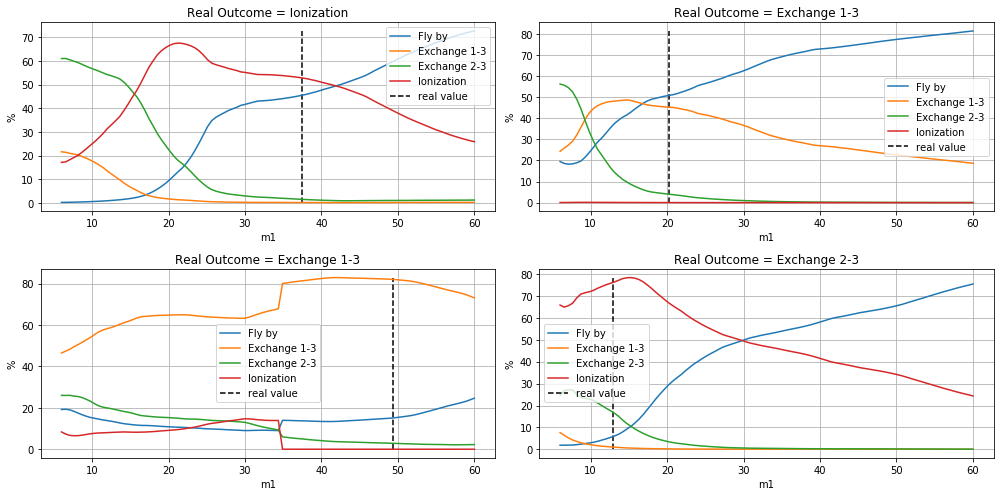

In [85]:
fig = plt.figure(figsize=(14,7))
for simulation, nplot in zip((4,458,500,220),range(221,225)):
    
    
    base_params = val_df.iloc[simulation]
    network_output_1D(base_params,'m1',transform_df,ax = fig.add_subplot(nplot)) 
    #plot_system(base_params,ax=fig.add_subplot(4,3,nplot*3+1,projection='3d'))    
plt.tight_layout()
plt.show()

As the $M_1$ parameter climbs, the binaries become more and more tightly bounded, so the fly-by probability steadily increases. The sudden jumps in the output function are due to the velovity suddenly passing the treshold of $v_{crit}$. It's interesting to note the ionization probability in the upper-left plot, that at first climbs buth then goes down again.

### Impact parameter


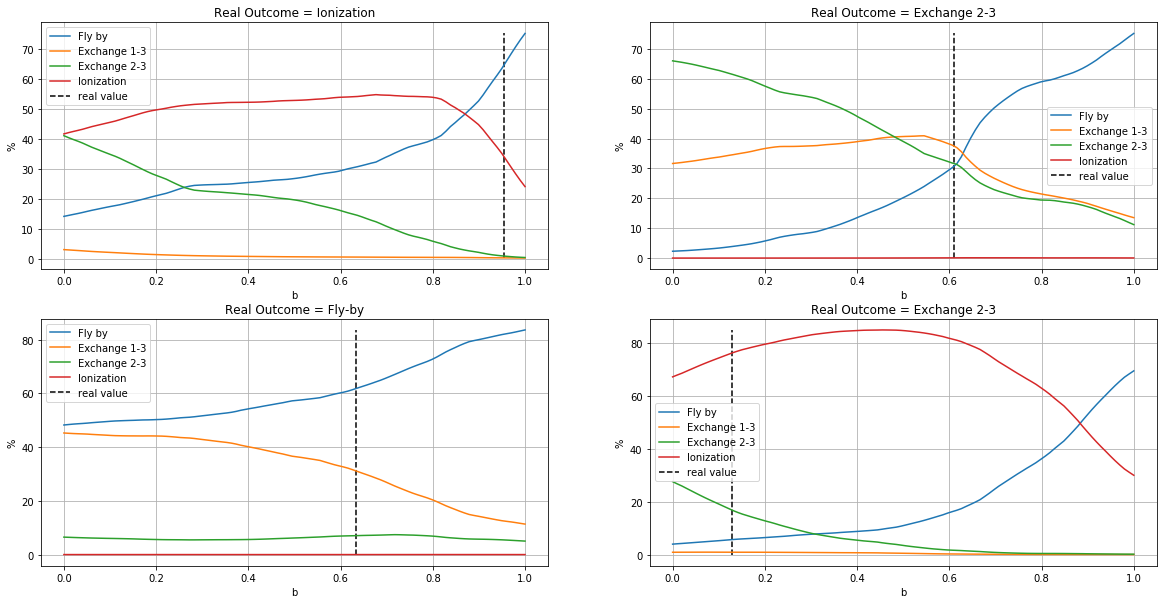

In [86]:
fig = plt.figure(figsize=(20,10))
for simulation, nplot in zip((2,10,100,220),range(221,225)):
    
    base_params = val_df.iloc[simulation]
    network_output_1D(base_params,'b',transform_df,ax = fig.add_subplot(nplot) )
    
plt.show()

These 4 plots show how the network output is affected by the b parameter changes. As we can expect the probability of fly-by increases as $b$ approaches $b_{max}$ and other outcomes become less probable, usually following a similar pattern.

### $M_3$

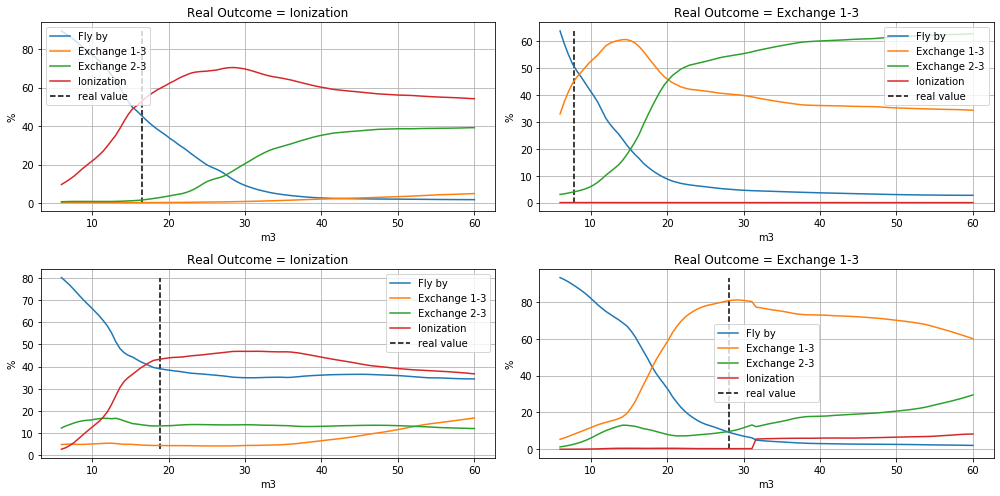

In [87]:
fig = plt.figure(figsize=(14,7))
for simulation, nplot in zip((4,458,2113,222),range(221,225)):
    
    
    base_params = val_df.iloc[simulation]
    network_output_1D(base_params,'m3',transform_df,ax = fig.add_subplot(nplot)) 
    #plot_system(base_params,ax=fig.add_subplot(4,3,nplot*3+1,projection='3d'))    
plt.tight_layout()
plt.show()

### $\phi$ and $\theta$

In this higly symmetrical system the variables $\phi$ and $\theta$ are both varied at the same time, as we can see the exchange does not depend much on theta, but almost exclusevly on phi, with a remarkable simmetry, signalling that the exchange happens with the first black hole the single encounters.

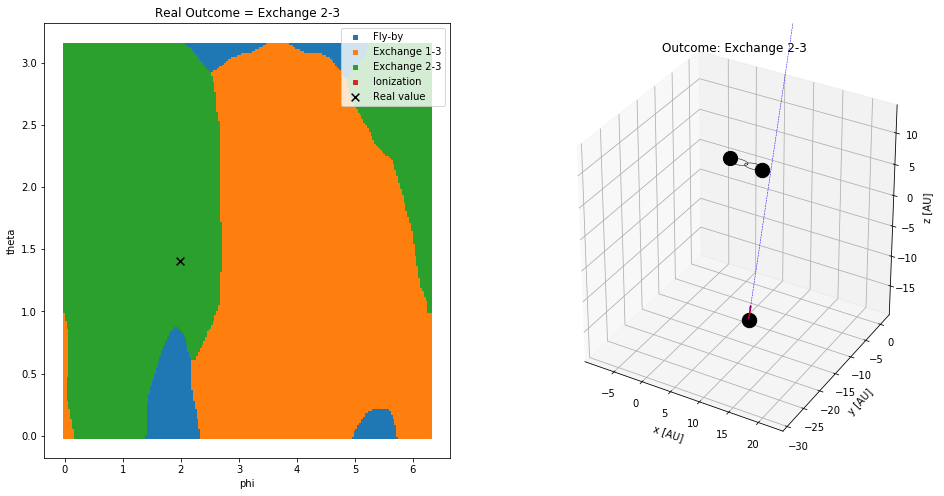

In [92]:
base_params = val_df.iloc[2116]
base_params.psi = 0

fig= plt.figure(figsize=[16,8])
ax1 = fig.add_subplot(121)
network_output_2D(base_params,('phi','theta'),transform_df,res=200,ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_system(base_params,ax=ax2)

### $M_1$ vs $M_2$

Even if the network has never seen a more massive $M_2$ than a $M_1$, it still can somewhat predict that the output function should be simmetrical with respect to the diagonal of the plot. This behaviour can be seen approxximated around the diagonal.

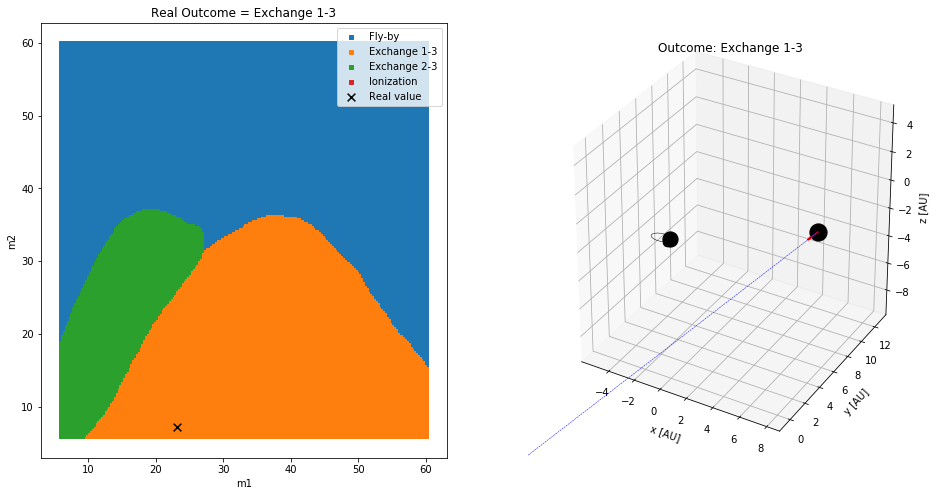

In [93]:
base_params = val_df.iloc[219]

fig= plt.figure(figsize=[16,8])
ax1 = fig.add_subplot(121)
network_output_2D(base_params,('m1','m2'),transform_df,res=200,ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
plot_system(base_params,ax=ax2,D=15)

### Semi-major axis vs and $v_{\infty}$

These variables were chosen to be seen together since $v_{crit} \propto \frac{1}{\sqrt{a}}$ so it is to be expected that the ionization probability will show similar behaviour. The network actually has learned this dependcy.

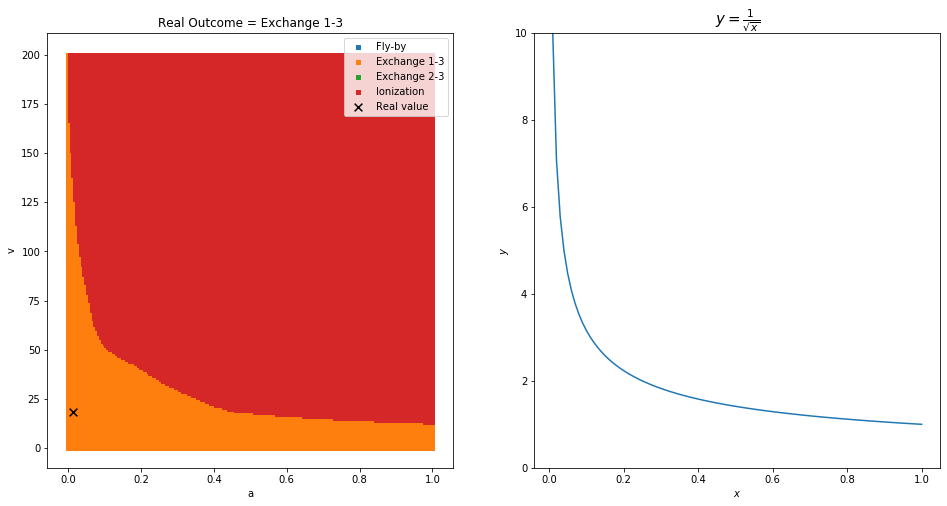

In [94]:
base_params = val_df.iloc[219]

fig= plt.figure(figsize=[16,8])
ax1 = fig.add_subplot(121)
network_output_2D(base_params,('a','v'),transform_df,res=200,ax=ax1)

ax2 = fig.add_subplot(122)
a = np.linspace(0.01,1,100)
ax2.set_title('$y = \\frac{1}{\sqrt{x}}$',fontsize=15)
ax2.plot(a,1/np.sqrt(a))
ax2.set_ylabel('$y$')
ax2.set_xlabel('$x$')
ax2.set_ylim(0,10)
plt.show()

### How does the complexity of the network changes over the training?
This answer will be answered qualitatively, by training the network and seeing how the topological map changes "complexity" as the training goes on. 

In [96]:
Ni = len(transform_df.mask) # Input nodes
Nh = [256 , 256, 256, 256 ] # Hidden nodes
No = 4                      # Output nodes

pDrop = 0.3            # Dropout

First_net = Net4(Ni , Nh , No , pDrop)

# Optimizer inizialization
lr           = 0.002#1e-3
weight_decay = 2e-5 # Paramter used to calibrate regularization
optimizer = optim.Adamax(First_net.parameters() , lr = lr , weight_decay = weight_decay)

# Loss function
class_weights = torch.Tensor([ 0.23 , 0.23 , 0.31 , 0.23 ])
loss_fn = torch.nn.CrossEntropyLoss(weight = class_weights )

train_losses, val_losses = [],[]
topo_out_labels = []
for i in range(5):
    # topo_out_labels.append(network_output_2D(base_params,('a','b'),transform_df,plot=False,res=80)[2])
    tr_l, vl_l = train_func(First_net=First_net,
            device=device, 
            train_dataloader=train_dataloader, 
            val_dataloader=val_dataloader,
            loss_fn=loss_fn, 
            optimizer=optimizer,
            verbose=0,num_epochs=10)
    train_losses.append(tr_l)
    val_losses.append(vl_l)
    
    base_params = val_df.iloc[2113]

    topo_out_labels.append(network_output_2D(base_params,('phi','theta'),transform_df,plot=False,res=80)[2])

Network initialized
EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10
EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10
EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10
EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10
EPOCH 1/10
EPOCH 2/10
EPOCH 3/10
EPOCH 4/10
EPOCH 5/10
EPOCH 6/10
EPOCH 7/10
EPOCH 8/10
EPOCH 9/10
EPOCH 10/10


C:\Users\luca3\Anaconda3\envs\tfl\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\Users\luca3\Anaconda3\envs\tfl\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


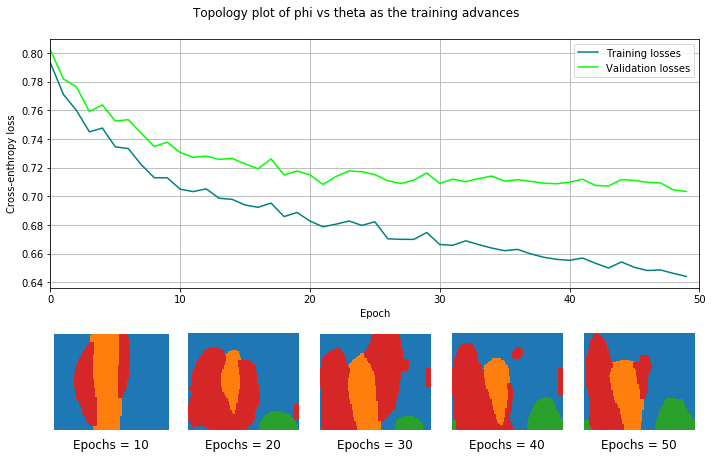

In [99]:
train_losses = torch.tensor(train_losses).flatten()
val_losses = torch.tensor(val_losses).flatten()
plt.figure(figsize=[10,6])
plt.suptitle('Topology plot of phi vs theta as the training advances',y=1.05)
plt.subplot2grid((3,5),(0,0),colspan=5,rowspan=2)

plt.plot(train_losses, label = 'Training losses',   color = 'teal'  )
plt.plot(val_losses,   label = 'Validation losses', color ='lime' )
#plt.vlines([9,19,29,39,49],[train_losses.min()]*5,[val_losses.max()]*5)
plt.ylabel('Cross-enthropy loss')
plt.xlabel('Epoch')
plt.xlim(-0,50)
plt.legend()
plt.grid()

col1flat,col2flat = network_output_2D(base_params,('phi','theta'),transform_df,plot=False,res=80)[0]
for i,topo in enumerate(topo_out_labels):
    ax = plt.subplot2grid((3,5),(2,i))


    colors = np.array(['C0','C1','C2','C3'])
    y = np.array(topo, dtype=int)

    for j in np.arange(4):
        mask = y == j
        ax.scatter(col1flat[mask], col2flat[mask], c=colors[j], s=10, marker='s',label = outcomes[j])

    #ax.scatter(*real_value, c='black', s=60, marker='x',label = 'Real value')

    ax.set_title('Epochs = '+str((i+1)*10),y=-0.2)
    ax.axis('off')
    #ax.set_ylabel('ah')
plt.tight_layout()
#plt.savefig('topology_vs_training.png')
plt.show()



The maps becomes more and more detailed for the first 30 epochs, but after this threshold the changes in the output seem to be randomly changing around a stable configuration.

### Probability of fly-by with respect to the ratio $\frac{m_3}{m_1+m_2}$

From the theory we know that probability of a fly-by is strongly linked to this ratio, so I wanted to see how the network predicts this variable will affect the output.

To do this, I calculated the fly-by proability for 1000 different initial conditions and for each 100 different $\frac{m_3}{m_1+m_2}$ in the range $[0,3]$ and averaging over all of them, obtaining a marginalization of the probability distribution. 

The histogram below shows how the parameter space was probed, signalling the regions where we expect the network to have a poor performance, in particular near 0. 

In [100]:
fly_by_prob = np.zeros(100)

num = 1000
for i in np.arange(num):
    base_params = val_df.iloc[i]
    cols_extremes['m3'] = (0, 3*(base_params.m1+base_params.m2) )

    
    _,out_sm,_ = network_output_1D(base_params,'m3',transform_df,plot=False)
    
    fly_by_prob += out_sm[:,0]

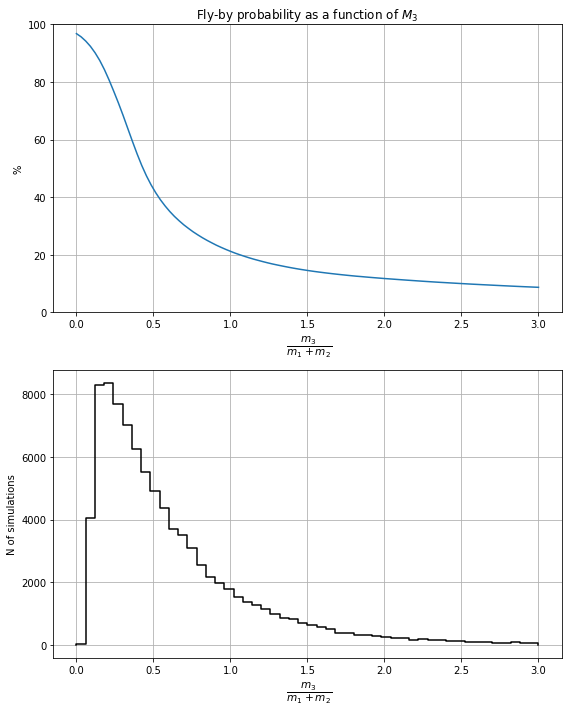

In [101]:
plt.figure(figsize=[8,10])
plt.subplot2grid((2,1),(0,0))

plt.title('Fly-by probability as a function of $M_3$')
plt.plot(np.linspace(0,3,num=100),fly_by_prob/num)
plt.ylabel('%')
plt.xlabel(' $\\frac{m_3}{m_1+m_2}$',fontsize=15)
plt.ylim(0,100)
plt.grid()
#plt.show()

heights,edges = hist_for_step(*np.histogram(train_df.m3/(train_df.m1+train_df.m2),bins=50,range=[0,3],density=False))
plt.subplot2grid((2,1),(1,0))
plt.step(edges , heights , color='black'  ,label='Velocity')
plt.xlabel(' $\\frac{m_3}{m_1+m_2}$',fontsize=15)
plt.ylabel('N of simulations')
plt.grid()

plt.tight_layout()
plt.show()

## Conclusions

This project had the aim to show that machine learning tools can be useful in the prediction of outcomes of 3-body encounters.
The accuracy is not great overall, being around 70% over 4 possible classes, but it must be considered that the chaoticness of a gravitational interaction can lead to what can be considere an almost totally random outcome. The Fact that such a high (in context) accuracy was achieved with this rather crude algorithm can point to possible advancements in the future, and, whenever this loss in accuracy is acceptable,  making it possible to cut the computational times of such simulation from taking months to taking seconds.

# Appendix 1: Gridsearch

The next section is dedicated to the gridesearch of the best parameters.
A few gridsearches have been performed. This example shown below shows that adding the Eccentricity anomaly parameter to the search does not actually matter much

In [138]:
####GRIDSEARCH
cv1 , cv2  = train_test_split(train_df,  test_size=2/3, stratify=train_df.OUTCOME, shuffle=True, random_state=0)
cv2 , cv3  = train_test_split(cv2     ,  test_size=0.5, stratify=cv2.OUTCOME,     shuffle=True, random_state=0)
cvs = [cv1,cv2,cv3]


col_to_normalize = ['m1' , 'm2',  'm3' , 'a' , 'e' , 'v']
angles1          = angles + ['Ecc_Anomaly']


iterator =  [NormalizeDataFrame(means,stds,col_to_normalize,angles1, v_crit_ind=True,m2_as_ratio=True),
             NormalizeDataFrame(means,stds,col_to_normalize,angles,v_crit_ind=True,m2_as_ratio=True)]

            #[NormalizeDataFrame(means,stds,col_to_normalize,angles,v_crit_ind=True),
           # NormalizeDataFrame(means,stds,col_to_normalize1,angles,v_crit_ind=True,m2_as_ratio=True),

columns=['Parameter','cv1','cv2','cv3','mean','acc','val_loss_logcv1','val_loss_logcv2','val_loss_logcv3']

null_log = np.zeros( [len( iterator) , len(columns)] ) 
null_log.fill(None)
log = pd.DataFrame(null_log, columns=columns,dtype=object)

log.Parameter = iterator
for i,ah in enumerate(iterator):

    transform_df = ah#NormalizeDataFrame(means,stds,col_to_normalize,angles,v_crit_ind=True) 

    Ni = len(transform_df.mask) # Input nodes
    Nh = [256 , 256, 256, 256 ]
    No = 4                      # Output nodes

    pDrop = 0.3            # Dropout


    batch_size = 512
    # Optimizer inizialization
    lr           = 0.002#1e-3
    weight_decay = 2e-5 # Paramter used to calibrate regularization

    # Loss function
    class_weights = torch.Tensor([ 0.23 , 0.23 , 0.31 , 0.23 ])
    loss_fn = torch.nn.CrossEntropyLoss(weight = class_weights )


    acc = []
    for j in np.arange(3):
        cvss = cvs.copy()
        partial_val_df = cvss.pop(j)
        partial_train_df = pd.concat(cvss)

        train_dataloader = DataLoader(dfToTensorDataset( partial_train_df  , transform_df, transform = None, mask = mask),
                                      batch_size = batch_size , shuffle = True  , num_workers=num_workers)
        
        val_dataloader = DataLoader(dfToTensorDataset( partial_val_df  , transform_df, transform = None, mask = mask),
                                      batch_size = len(partial_val_df) , shuffle = False  , num_workers=num_workers)
        
        First_net = Net4(Ni,Nh,No,pDrop)
        optimizer = optim.Adamax(First_net.parameters() , lr = lr , weight_decay = weight_decay)
 
        num_epochs = 25
        verbose = 0 
        train_losses, val_losses = train_func(First_net=First_net,
                                                device=device, 
                                                train_dataloader=train_dataloader, 
                                                val_dataloader=val_dataloader,
                                                loss_fn=loss_fn, 
                                                optimizer=optimizer,
                                                verbose=verbose,
                                                 num_epochs = num_epochs)


        log['cv' + str(j+1)][i]               = val_losses[-1]
        log['val_loss_logcv' + str(j+1) ][i]  = val_losses
        conc_out,conc_label,_ = test_epoch( First_net, device,val_dataloader,loss_fn) 
        sm = torch.nn.Softmax(dim=1)
        val_out        = np.array(sm(conc_out.cpu()))
        val_out_labels = np.argmax(val_out,axis=1)
        acc.append( sum( np.array(conc_label.cpu()) == val_out_labels)/val_out_labels.shape)

    log['acc'][i] = np.mean(acc)
    log['mean'][i] = log[['cv1','cv2','cv3']].iloc[i].mean()

Network initialized
EPOCH 1/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


EPOCH 2/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


EPOCH 3/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH 4/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


EPOCH 5/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


EPOCH 6/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


EPOCH 7/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


EPOCH 8/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


EPOCH 9/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH 10/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH 11/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH 12/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


EPOCH 13/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


EPOCH 14/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


EPOCH 15/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 16/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


EPOCH 17/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 18/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 19/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


EPOCH 20/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


EPOCH 21/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH 22/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH 23/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


EPOCH 24/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


EPOCH 25/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Network initialized
EPOCH 1/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


EPOCH 2/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


EPOCH 3/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


EPOCH 4/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


EPOCH 5/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


EPOCH 6/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


EPOCH 7/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH 8/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


EPOCH 9/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


EPOCH 10/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


EPOCH 11/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH 12/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH 13/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


EPOCH 14/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


EPOCH 15/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


EPOCH 16/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 17/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


EPOCH 18/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


EPOCH 19/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.10it/s]


EPOCH 20/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


EPOCH 21/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 22/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


EPOCH 23/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH 24/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


EPOCH 25/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


Network initialized
EPOCH 1/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


EPOCH 2/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


EPOCH 3/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 4/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


EPOCH 5/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


EPOCH 6/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 7/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 8/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH 9/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


EPOCH 10/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH 11/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


EPOCH 12/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


EPOCH 13/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH 14/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH 15/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


EPOCH 16/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 17/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH 18/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH 19/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH 20/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


EPOCH 21/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


EPOCH 22/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH 23/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 24/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


EPOCH 25/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Network initialized
EPOCH 1/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH 2/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 3/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH 4/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH 5/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH 6/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


EPOCH 7/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


EPOCH 8/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 9/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH 10/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH 11/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 12/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH 13/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 14/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 15/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


EPOCH 16/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 17/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH 18/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 19/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH 20/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


EPOCH 21/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 22/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH 23/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


EPOCH 24/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH 25/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


Network initialized
EPOCH 1/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


EPOCH 2/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH 3/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


EPOCH 4/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH 5/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


EPOCH 6/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH 7/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


EPOCH 8/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH 9/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH 10/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 11/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH 12/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH 13/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH 14/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH 15/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH 16/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 17/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


EPOCH 18/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


EPOCH 19/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 20/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 21/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


EPOCH 22/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


EPOCH 23/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH 24/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


EPOCH 25/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Network initialized
EPOCH 1/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 2/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


EPOCH 3/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH 4/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


EPOCH 5/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


EPOCH 6/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


EPOCH 7/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


EPOCH 8/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH 9/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


EPOCH 10/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


EPOCH 11/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


EPOCH 12/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


EPOCH 13/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


EPOCH 14/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


EPOCH 15/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


EPOCH 16/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


EPOCH 17/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


EPOCH 18/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


EPOCH 19/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


EPOCH 20/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


EPOCH 21/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


EPOCH 22/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


EPOCH 23/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


EPOCH 24/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


EPOCH 25/25


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


In [139]:
log

,Parameter,cv1,cv2,cv3,mean,acc,val_loss_logcv1,val_loss_logcv2,val_loss_logcv3
0,<__main__.NormalizeDataFrame object at 0x00000...,tensor(0.7234),tensor(0.7158),tensor(0.7235),0.720884,0.692544,"[tensor(0.8287), tensor(0.8058), tensor(0.8015...","[tensor(0.8276), tensor(0.7969), tensor(0.7892...","[tensor(0.8334), tensor(0.8056), tensor(0.8005..."
1,<__main__.NormalizeDataFrame object at 0x00000...,tensor(0.7240),tensor(0.7176),tensor(0.7226),0.721399,0.6931,"[tensor(0.8201), tensor(0.7967), tensor(0.7815...","[tensor(0.8154), tensor(0.7912), tensor(0.7835...","[tensor(0.8165), tensor(0.7940), tensor(0.7847..."


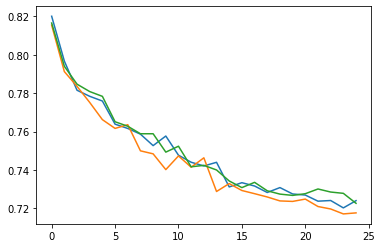

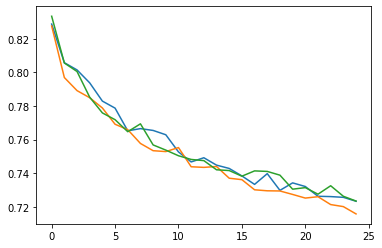

In [143]:
which  = 1
plt.plot(log.val_loss_logcv1[which])
plt.plot(log.val_loss_logcv2[which])
plt.plot(log.val_loss_logcv3[which])
plt.show()
which  = 0
plt.plot(log.val_loss_logcv1[which])
plt.plot(log.val_loss_logcv2[which])
plt.plot(log.val_loss_logcv3[which])

In [114]:
log1

,Parameter,cv1,cv2,cv3,mean,acc,val_loss_logcv1,val_loss_logcv2,val_loss_logcv3
0,<__main__.NormalizeDataFrame object at 0x00000...,tensor(0.7297),<__main__.NormalizeDataFrame object at 0x00000...,tensor(0.7286),0.727577,0.6795,"[tensor(0.8006), tensor(0.7811), tensor(0.7774...","[tensor(0.8111), tensor(0.7820), tensor(0.7716...","[tensor(0.8050), tensor(0.7947), tensor(0.7800..."
1,<__main__.NormalizeDataFrame object at 0x00000...,tensor(0.6954),NaN,tensor(0.7010),0.695703,0.696011,"[tensor(0.8020), tensor(0.7756), tensor(0.7631...","[tensor(0.7906), tensor(0.7655), tensor(0.7561...","[tensor(0.8036), tensor(0.7764), tensor(0.7616..."
2,<__main__.NormalizeDataFrame object at 0x00000...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
